In [1]:
import pandas as pd
import pickle
from PIL import Image
import numpy as np
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import shelve
import math
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import pickle5 as pickle
import scipy.io
from scipy.stats import sem
import dataframe_image as dfi

In [2]:
##dataloader
from torch.utils.data import Dataset, DataLoader

class FaceDataset(Dataset):
    def __init__(self, txt_path, img_dir, transforms = None):
        df = pickle.load(open(txt_path, "rb"))
        df['img'] = df['img'].str.replace("/mmfs1/data/schwarex/neuralNetworks/identity/datasets/img_align_celeba",
                                          img_dir)
        self.txt_path = txt_path
        self.y = df['new_label']
        self.x = df['img']
        self.n_samples = len(df)
        self.transforms = transforms

        self.mu = torch.randn(1503)
        m = torch.distributions.gamma.Gamma(torch.ones(1503), torch.ones(1503) * 20)
        self.sigma = m.sample()

    def __len__(self):
        return self.n_samples


    def __getitem__(self, index):
        image = Image.open(self.x[index]).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        label = self.y[index]
        base_reward = torch.randn(1)
        reward = base_reward * self.sigma[label] + self.mu[label]
        data = [image, label, reward]

        return data

    
transform = transforms.Compose([transforms.CenterCrop(178),  #original image size = (178, 218)
                                transforms.Resize(128),
                                transforms.ToTensor()])       
                                                                                                                                                     
train_dataset = FaceDataset(txt_path = '/data/zhouabx/celebA/train_SUBSET.pkl',
                            img_dir = '/mmfs1/data/zhouabx/celebA/img_align_celeba/',
                            transforms = transform)

trainloader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)

In [3]:
class MultitaskNetDense(nn.Module):
    def __init__(self, k):
        super(MultitaskNetDense, self).__init__()
        self.k = k
        #(128, 128, 3)
        self.bn1 = nn.BatchNorm2d(3) 
        self.encConv1 = nn.Conv2d(3, k, kernel_size = 4, stride = 2, padding = 1) # -> 16 x 64 x 64
        self.bn2 = nn.BatchNorm2d(k)

        # first dense block
        self.encConv2 = nn.Conv2d(k, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn3 = nn.BatchNorm2d(k * 2)
        self.encConv3 = nn.Conv2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn4 = nn.BatchNorm2d(k * 3)
        self.encConv4 = nn.Conv2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn5 = nn.BatchNorm2d(k)

        # second dense block
        self.encConv5 = nn.Conv2d(k, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn6 = nn.BatchNorm2d(k * 2)
        self.encConv6 = nn.Conv2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn7 = nn.BatchNorm2d(k * 3)
        self.encConv7 = nn.Conv2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn8 = nn.BatchNorm2d(k)
        
        # third dense block
        self.encConv8 = nn.Conv2d(k, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn9 = nn.BatchNorm2d(k * 2)
        self.encConv9 = nn.Conv2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn10 = nn.BatchNorm2d(k * 3)
        self.encConv10 = nn.Conv2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn11 = nn.BatchNorm2d(k) 
        
        # fully connected part
        self.encoder_mu = nn.Linear(k * 32 * 32, 2048)  
        self.encoder_logVar = nn.Linear (k * 32 * 32, 2048)         
        
        #add dropout layer
        self.dropout = nn.Dropout2d(0.25) 
        
        self.decFC1 = nn.Linear(2048, k * 32 * 32)
        self.bn12 = nn.BatchNorm2d(k)
        
        self.decConv1 = nn.ConvTranspose2d(k, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn13 = nn.BatchNorm2d(k * 2)
        self.decConv2 = nn.ConvTranspose2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn14 = nn.BatchNorm2d(k * 3)
        self.decConv3 = nn.ConvTranspose2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn15 = nn.BatchNorm2d(k)
 
        self.decConv4 = nn.ConvTranspose2d(k, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn16 = nn.BatchNorm2d(k * 2)
        self.decConv5 = nn.ConvTranspose2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn17 = nn.BatchNorm2d(k * 3)
        self.decConv6 = nn.ConvTranspose2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn18 = nn.BatchNorm2d(k)
        
        self.decConv7 = nn.ConvTranspose2d(k, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn19 = nn.BatchNorm2d(k * 2)
        self.decConv8 = nn.ConvTranspose2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn20 = nn.BatchNorm2d(k * 3)
        self.decConv9 = nn.ConvTranspose2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn21 = nn.BatchNorm2d(k)
        
        self.decConv10 = nn.ConvTranspose2d(k, 3, kernel_size = 4, stride = 2, padding = 1) 
        self.bn22 = nn.BatchNorm2d(3)
                
            
        ## q network
        self.qnetwork = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )  
        
        
    def encoder(self, x):
        # first dense block
        x1 = F.relu(self.encConv1(self.bn1(x)))
        x2 = F.relu(self.encConv2(self.bn2(x1)))       
        x = torch.cat((x1, x2), 1) 
        
        x3 = F.relu(self.encConv3(self.bn3(x)))
        x = torch.cat((x1, x2, x3), 1)
        
        x4 = F.relu(self.encConv4(self.bn4(x)))
        x4 = F.avg_pool2d(x4, 2)
        
        # second dense block
        x5 = F.relu(self.encConv5(self.bn5(x4)))
        x = torch.cat((x4, x5), 1)
        x6 = F.relu(self.encConv6(self.bn6(x)))
        x = torch.cat((x4, x5, x6), 1)
        
        x7 = F.relu(self.encConv7(self.bn7(x)))          
       
        # third dense block
        x8 = F.relu(self.encConv8(self.bn8(x7)))
        x = torch.cat((x7, x8), 1)
        x9 = F.relu(self.encConv9(self.bn9(x)))
        x = torch.cat((x7, x8, x9), 1)
        
        x10 = F.relu(self.encConv10(self.bn10(x)))                
                    
        x = self.bn11(x10)
                
        x = x.view(-1, self.k * 32 * 32)
        x = self.dropout(x)
        return self.encoder_mu(x), self.encoder_logVar(x)                   
 

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5 * logVar) #logVar = log(sigma^2) -> 0.5*logVar.exp = sigma
        eps = torch.randn_like(std)
        # reparametrisation trick
        return mu + std * eps
    
    
    def decoder(self, z):
        # first dense block
        x = F.relu(self.decFC1(z))
        
        x11 = x.view(-1, self.k, 32, 32)      
        x12 = F.relu(self.decConv1(self.bn12(x11)))             
        x = torch.cat((x11, x12), 1)         
        
        x13 = F.relu(self.decConv2(self.bn13(x)))
        x = torch.cat((x11, x12, x13), 1)  
        
        x14 = F.relu(self.decConv3(self.bn14(x)))
        
        # second dense block
        x15 = F.relu(self.decConv4(self.bn15(x14)))
        x = torch.cat((x14, x15), 1) 
        
        x16 = F.relu(self.decConv5(self.bn16(x)))
        x = torch.cat((x14, x15, x16), 1)  
        
        x17 = F.relu(self.decConv6(self.bn17(x)))
        
        # third dense block
        x18 = F.relu(self.decConv7(self.bn18(x17)))
        x = torch.cat((x17, x18), 1) 
        
        x19 = F.relu(self.decConv8(self.bn19(x)))
        x = torch.cat((x17, x18, x19), 1) 
        
        x20 = F.relu(self.decConv9(self.bn20(x)))        
        x20 = F.interpolate(x20, [64, 64])
              
        x21 = F.relu(self.decConv10(self.bn21(x20)))
        x = self.bn22(x21)
        return x
    
    def q(self, z):
        return self.qnetwork(z)
 
    def forward(self, x):  # encoder -> reparameterization -> decoder
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        qvalues = self.q(z)
        reconstruction = self.decoder(z)
        return qvalues, reconstruction, mu, logVar
    
model = MultitaskNetDense(64)
model.cuda()

MultitaskNetDense(
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv4): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv6): Conv2d(128, 64, kernel_size=(3

In [4]:
checkpoint = torch.load('/mmfs1/data/zhouabx/KDEF/KDEF_RDM_new/reward_only/2023_May_Reward/CelebA_train_results/only_reward.ckp',
                        map_location = 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

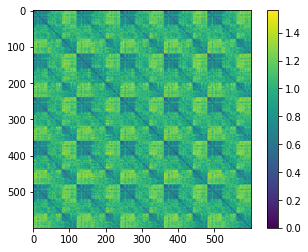

In [5]:
#test on KDEF dataset subset A (note that this is described as dataset B in the paper, and vice versa the dataset that is described as dataset A in the paper is named dataset B in the code)
#open subset_A
Dataset_A = pickle.load(open('/mmfs1/data/zhouabx/KDEF/data_A_with_id_expression_direction.pkl', "rb"))

KDEF_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor()])

mu_list_A = []
model.eval()
with torch.no_grad():
    for idx, row in Dataset_A.iterrows():
        image = Image.open(Dataset_A['path'][idx]).convert('RGB')
        image = KDEF_transform(image)
        qvalues, reconstruction, mu, logVar = model(image[None, :].cuda())
        mu_list_A.append(mu[0, :])
A_mus = torch.stack((mu_list_A))

#save mu
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/RL/KDEF_test_results_AB/"
with open(path + 'mu_values_A.pkl', 'wb') as pickle_out:
     pickle.dump(A_mus, pickle_out)      
    
Dataset_A['mu_A'] = A_mus.cpu().detach()
Dataset_A_with_mu = Dataset_A  

#average the L and R         
Dataset_A_with_mu["new_direction"] = np.where((Dataset_A_with_mu["direction"].values == "HR") | (Dataset_A_with_mu["direction"] == "HL"), 
         "H", 
         np.where((Dataset_A_with_mu["direction"].values == "FR") | (Dataset_A_with_mu["direction"] == "FL"), 
         "F", 
         Dataset_A_with_mu["direction"].values))        
         

group_index = Dataset_A_with_mu.agg('{0[expression]} and {0[new_direction]} and {0[id]}'.format, axis = 1)

ids = np.unique(group_index)
g_mean = np.array([np.mean(A_mus.cpu().detach().numpy()[group_index == i, 0:], axis = 0) for i in ids])

df_LR_ave = pd.DataFrame(data = np.array(list(map(lambda x : np.str.split(x, sep = " and "), ids))))
df_LR_ave.columns = ["expression", "direction", "id"]
df_LR_ave['mu_A'] = g_mean.tolist()
                
#label everything
dictionary_emotion_A = {'AF' : 0, 'AN' : 1, 'HA' : 2, 'NE' : 3, 'SA' : 4}
df_LR_ave['emotionlabel_A'] = df_LR_ave['expression'].map(dictionary_emotion_A)

dictionary_view_A = {'F' : 0, 'H' : 1, 'S' : 2}
df_LR_ave['viewlabel_A'] = df_LR_ave['direction'].map(dictionary_view_A)

dictionary_id_A = {'AF01' : 0, 'AF02' : 1, 'AF03' : 2, 'AF04' : 3, 'AF06' : 4, 'AF07' : 5, 'AF09' : 6, 'AF13' : 7, 'AF14' : 8, 'AF16' : 9,
 'AF20' : 10, 'AF21' : 11, 'AF22' : 12, 'AF24' : 13, 'AF25': 14, 'AF28' : 15, 'AF29' : 16, 'AF30' : 17, 'AF32' : 18, 
 'AF33' : 19, 'AM01' : 20, 'AM05' : 21, 'AM06' : 22, 'AM08' : 23, 'AM09' : 24, 'AM10' : 25, 'AM11' : 26, 'AM13' : 27,
 'AM14' : 28, 'AM15' : 29, 'AM16' : 30, 'AM22' : 31, 'AM23' : 32, 'AM24' : 33, 'AM25' : 34, 'AM28' : 35, 'AM29' : 36,
 'AM30' : 37, 'AM31' : 38, 'AM35' : 39}
df_LR_ave['idlabel_A'] = df_LR_ave['id'].map(dictionary_id_A)

#order everything
New_Data_A = df_LR_ave.sort_values(by = ['emotionlabel_A', 'viewlabel_A', 'idlabel_A'])
#reset the index and save the dataframe in New_Data_A_with_mu
New_Data_A_with_mu = New_Data_A.reset_index(drop = True)  

# create array features
array_features_A = [New_Data_A_with_mu['mu_A'][0]]
for i in range(1, New_Data_A_with_mu.shape[0]):
    array_features_A = np.concatenate((array_features_A, [New_Data_A_with_mu['mu_A'][i]]), axis = 0)

# substract baseline
average_vector = np.mean(array_features_A, axis = 0)
centered_data = array_features_A - average_vector

# attach centered_feature
New_Data_A_with_mu['centered_feature'] = [centered_data[i] for i in range(len(centered_data))]

l_A = [None] * 600
for _ in range (len(New_Data_A_with_mu)):
    l_A [New_Data_A_with_mu.iloc[_]['idlabel_A'] + 
         40 * New_Data_A_with_mu.iloc[_]['viewlabel_A'] + 
         40 * 3 * New_Data_A_with_mu.iloc[_]['emotionlabel_A']] = New_Data_A_with_mu.iloc[_]['centered_feature']      

RDM_A = 1 - np.corrcoef(l_A)      

plt.imshow(RDM_A) ## note that this is named RDM B in the paper
plt.colorbar()

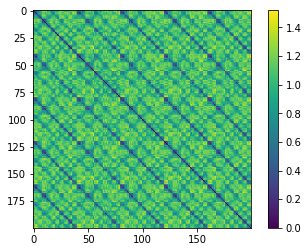

In [6]:
Dataset_B = pickle.load(open('/mmfs1/data/zhouabx/KDEF/data_B_with_id_expression_direction.pkl', "rb"))   

KDEF_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor()])

mu_list_B = []
model.eval()
with torch.no_grad():
    for idx, row in Dataset_B.iterrows():
        image = Image.open(Dataset_B['path'][idx]).convert('RGB')
        image = KDEF_transform(image)
        qvalues, reconstruction, mu, logVar = model(image[None, :].cuda())
        mu_list_B.append(mu[0, :])      
B_mus = torch.stack((mu_list_B))

#save mu
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/RL/KDEF_test_results_AB/"
with open(path + 'mu_values_B.pkl', 'wb') as pickle_out:
     pickle.dump(B_mus, pickle_out)

#label everything
dictionary_emotion = {'AF' : 0, 'AN' : 1, 'HA' : 2, 'NE' : 3, 'SA' : 4}
Dataset_B['emotionlabel'] = Dataset_B['expression'].map(dictionary_emotion)

dictionary_view = {'FL' : 0, 'FR' : 1, 'HL' : 2, 'HR' : 3, 'S' : 4}
Dataset_B['viewlabel'] = Dataset_B['direction'].map(dictionary_view)

dictionary_id = {'AF01' : 0, 'AF02' : 1, 'AF03' : 2, 'AF04' : 3, 'AM08' : 4, 'AM10' : 5, 'AM11' : 6, 'AM25': 7}
Dataset_B['idlabel'] = Dataset_B['id'].map(dictionary_id)

#add mu to the dataset
Dataset_B['mu_B'] = B_mus.cpu().detach()

#order everything
New_Data_B = Dataset_B.sort_values(by = ['emotionlabel', 'viewlabel', 'idlabel'])
#reset the index and save the dataframe in New_Data_B_with_mu
New_Data_B_with_mu = New_Data_B.reset_index(drop = True)

# create array features
array_features_B = [New_Data_B_with_mu['mu_B'][0]]
for i in range(1, New_Data_B_with_mu.shape[0]):
    array_features_B = np.concatenate((array_features_B, [New_Data_B_with_mu['mu_B'][i]]), axis = 0)

# substract baseline
average_vector = np.mean(array_features_B, axis = 0)
centered_data = array_features_B - average_vector

# attach centered_feature
New_Data_B_with_mu['centered_feature'] = [centered_data[i] for i in range(len(centered_data))]

# create RDM
l = [None] * 200
for _ in range (len(New_Data_B_with_mu)):
    l [New_Data_B_with_mu.iloc[_]['idlabel'] + 
       8 * New_Data_B_with_mu.iloc[_]['viewlabel'] + 
       8 * 5 * New_Data_B_with_mu.iloc[_]['emotionlabel']] = New_Data_B_with_mu.iloc[_]['centered_feature']

RDM_B = 1 - np.corrcoef(l)

plt.imshow(RDM_B) ## note that this is named RDM A in the paper
plt.colorbar()

In [7]:
#save RDM value
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/RL/KDEF_test_results_AB/"
with open(path + 'RDM_value_A.pkl', 'wb') as pickle_out:
     pickle.dump(RDM_A, pickle_out)
        
with open(path + 'RDM_value_B.pkl', 'wb') as pickle_out:
     pickle.dump(RDM_B, pickle_out)

In [4]:
# open RDMs for KDEF A & B
RL_RDM_value_A = pickle.load(open('/mmfs1/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/RL/KDEF_test_results_AB/RDM_value_A.pkl',"rb"))
v_RL_RDM_A = RL_RDM_value_A[np.triu_indices(RL_RDM_value_A.shape[0], 1)]

RL_RDM_value_B = pickle.load(open('/mmfs1/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/RL/KDEF_test_results_AB/RDM_value_B.pkl',"rb"))
v_RL_RDM_B = RL_RDM_value_B[np.triu_indices(RL_RDM_value_B.shape[0], 1)]

In [5]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p16/'
vA_p16_rdms = []
v_vA_p16_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p16_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p16_rdms)):
    vector = vA_p16_rdms[i][np.triu_indices(vA_p16_rdms[i].shape[0], 1)]
    v_vA_p16_rdms.append(vector)
    
kendalltau_RL_and_vA_p16 = []
for i in range (len(v_vA_p16_rdms)):   
    kendalltau_RL_and_vA_p16.append(stats.kendalltau(v_RL_RDM_A, v_vA_p16_rdms[i]))
    
corr, _ = kendalltau_RL_and_vA_p16[0]
print('subset A RL and p16_e90_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p16[1]
print('subset A RL and p16_e90_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p16[2]
print('subset A RL and p16_e90_wind6 kendalltau: %.5f' % corr)

subset A RL and p16_e90_wind4 kendalltau: 0.03870
subset A RL and p16_e90_wind5 kendalltau: 0.02228
subset A RL and p16_e90_wind6 kendalltau: 0.00715


In [6]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p23/'
vA_p23_rdms = []
v_vA_p23_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p23_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p23_rdms)):
    vector = vA_p23_rdms[i][np.triu_indices(vA_p23_rdms[i].shape[0], 1)]
    v_vA_p23_rdms.append(vector)
    
kendalltau_RL_and_vA_p23 = []
for i in range (len(v_vA_p23_rdms)):   
    kendalltau_RL_and_vA_p23.append(stats.kendalltau(v_RL_RDM_A, v_vA_p23_rdms[i]))

corr, _ = kendalltau_RL_and_vA_p23[0]
print('subset A RL and p23_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p23[1]
print('subset A RL and p23_wind5 kendalltau: 0')
corr, _ = kendalltau_RL_and_vA_p23[2]
print('subset A RL and p23_wind6 kendalltau: 0')

subset A RL and p23_wind4 kendalltau: 0.00173
subset A RL and p23_wind5 kendalltau: 0
subset A RL and p23_wind6 kendalltau: 0


In [7]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p27/'
vA_p27_rdms = []
v_vA_p27_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p27_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p27_rdms)):
    vector = vA_p27_rdms[i][np.triu_indices(vA_p27_rdms[i].shape[0], 1)]
    v_vA_p27_rdms.append(vector)
    
kendalltau_RL_and_vA_p27 = []
for i in range (len(v_vA_p27_rdms)):   
    kendalltau_RL_and_vA_p27.append(stats.kendalltau(v_RL_RDM_A, v_vA_p27_rdms[i]))

corr, _ = kendalltau_RL_and_vA_p27[0]
print('subset A RL and p27_e100_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[1]
print('subset A RL and p27_e100_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[2]
print('subset A RL and p27_e100_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[3]
print('subset A RL and p27_e53_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[4]
print('subset A RL and p27_e53_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[5]
print('subset A RL and p27_e53_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[6]
print('subset A RL and p27_e60_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[7]
print('subset A RL and p27_e60_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[8]
print('subset A RL and p27_e60_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[9]
print('subset A RL and p27_e61_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[10]
print('subset A RL and p27_e61_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[11]
print('subset A RL and p27_e61_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[12]
print('subset A RL and p27_e62_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[13]
print('subset A RL and p27_e62_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p27[14]
print('subset A RL and p27_e62_wind6 kendalltau: %.5f' % corr)

subset A RL and p27_e100_wind4 kendalltau: 0.05108
subset A RL and p27_e100_wind5 kendalltau: 0.03120
subset A RL and p27_e100_wind6 kendalltau: 0.01040
subset A RL and p27_e53_wind4 kendalltau: 0.05754
subset A RL and p27_e53_wind5 kendalltau: 0.08037
subset A RL and p27_e53_wind6 kendalltau: 0.04018
subset A RL and p27_e60_wind4 kendalltau: 0.02814
subset A RL and p27_e60_wind5 kendalltau: 0.03350
subset A RL and p27_e60_wind6 kendalltau: 0.00629
subset A RL and p27_e61_wind4 kendalltau: 0.01209
subset A RL and p27_e61_wind5 kendalltau: 0.05340
subset A RL and p27_e61_wind6 kendalltau: 0.02197
subset A RL and p27_e62_wind4 kendalltau: 0.04432
subset A RL and p27_e62_wind5 kendalltau: 0.04972
subset A RL and p27_e62_wind6 kendalltau: 0.02828


In [8]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p28/'
vA_p28_rdms = []
v_vA_p28_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p28_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p28_rdms)):
    vector = vA_p28_rdms[i][np.triu_indices(vA_p28_rdms[i].shape[0], 1)]
    v_vA_p28_rdms.append(vector)
    
kendalltau_RL_and_vA_p28 = []
for i in range (len(v_vA_p28_rdms)):   
    kendalltau_RL_and_vA_p28.append(stats.kendalltau(v_RL_RDM_A, v_vA_p28_rdms[i]))

corr, _ = kendalltau_RL_and_vA_p28[0]
print('subset A RL and p28_e85_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p28[1]
print('subset A RL and p28_e85_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p28[2]
print('subset A RL and p28_e85_wind6 kendalltau: %.5f' % corr)

subset A RL and p28_e85_wind4 kendalltau: 0.03947
subset A RL and p28_e85_wind5 kendalltau: 0.00915
subset A RL and p28_e85_wind6 kendalltau: 0.00524


In [9]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p30/'
vA_p30_rdms = []
v_vA_p30_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p30_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p30_rdms)):
    vector = vA_p30_rdms[i][np.triu_indices(vA_p30_rdms[i].shape[0], 1)]
    v_vA_p30_rdms.append(vector)
    
kendalltau_RL_and_vA_p30 = []
for i in range (len(v_vA_p30_rdms)):   
    kendalltau_RL_and_vA_p30.append(stats.kendalltau(v_RL_RDM_A, v_vA_p30_rdms[i]))

corr, _ = kendalltau_RL_and_vA_p30[0]
print('subset A RL and p30_e8_wind4 kendalltau: 0')
corr, _ = kendalltau_RL_and_vA_p30[1]
print('subset A RL and p30_e8_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p30[2]
print('subset A RL and p30_e8_wind6 kendalltau: 0')

subset A RL and p30_e8_wind4 kendalltau: 0
subset A RL and p30_e8_wind5 kendalltau: 0.00203
subset A RL and p30_e8_wind6 kendalltau: 0


In [10]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p34/'
vA_p34_rdms = []
v_vA_p34_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p34_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p34_rdms)):
    vector = vA_p34_rdms[i][np.triu_indices(vA_p34_rdms[i].shape[0], 1)]
    v_vA_p34_rdms.append(vector)
    
kendalltau_RL_and_vA_p34 = []
for i in range (len(v_vA_p34_rdms)):   
    kendalltau_RL_and_vA_p34.append(stats.kendalltau(v_RL_RDM_A, v_vA_p34_rdms[i]))

corr, _ = kendalltau_RL_and_vA_p34[0]
print('subset A RL and p34_e23_wind4 kendalltau: 0')
corr, _ = kendalltau_RL_and_vA_p34[1]
print('subset A RL and p34_e23_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p34[2]
print('subset A RL and p34_e23_wind6 kendalltau: 0')
corr, _ = kendalltau_RL_and_vA_p34[3]
print('subset A RL and p34_e42_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p34[4]
print('subset A RL and p34_e42_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p34[5]
print('subset A RL and p34_e42_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p34[6]
print('subset A RL and p34_e44_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p34[7]
print('subset A RL and p34_e44_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p34[8]
print('subset A RL and p34_e44_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p34[9]
print('subset A RL and p43_e43_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p34[10]
print('subset A RL and p43_e43_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p34[11]
print('subset A RL and p43_e43_wind6 kendalltau: %.5f' % corr)

subset A RL and p34_e23_wind4 kendalltau: 0
subset A RL and p34_e23_wind5 kendalltau: 0.00115
subset A RL and p34_e23_wind6 kendalltau: 0
subset A RL and p34_e42_wind4 kendalltau: 0.01821
subset A RL and p34_e42_wind5 kendalltau: 0.00581
subset A RL and p34_e42_wind6 kendalltau: 0.00177
subset A RL and p34_e44_wind4 kendalltau: 0.02302
subset A RL and p34_e44_wind5 kendalltau: 0.01564
subset A RL and p34_e44_wind6 kendalltau: 0.00271
subset A RL and p43_e43_wind4 kendalltau: 0.07490
subset A RL and p43_e43_wind5 kendalltau: 0.02560
subset A RL and p43_e43_wind6 kendalltau: 0.00410


In [11]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p36/'
vA_p36_rdms = []
v_vA_p36_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p36_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p36_rdms)):
    vector = vA_p36_rdms[i][np.triu_indices(vA_p36_rdms[i].shape[0], 1)]
    v_vA_p36_rdms.append(vector)
    
kendalltau_RL_and_vA_p36 = []
for i in range (len(v_vA_p36_rdms)):   
    kendalltau_RL_and_vA_p36.append(stats.kendalltau(v_RL_RDM_A, v_vA_p36_rdms[i]))

corr, _ = kendalltau_RL_and_vA_p36[0]
print('subset A RL and p36_e64_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p36[1]
print('subset A RL and p36_e64_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p36[2]
print('subset A RL and p36_e64_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p36[3]
print('subset A RL and p36_e69_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p36[4]
print('subset A RL and p36_e69_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p36[5]
print('subset A RL and p36_e69_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p36[6]
print('subset A RL and p36_e70_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p36[7]
print('subset A RL and p36_e70_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p36[8]
print('subset A RL and p36_e70_wind6 kendalltau: %.5f' % corr)

subset A RL and p36_e64_wind4 kendalltau: 0.09888
subset A RL and p36_e64_wind5 kendalltau: 0.06915
subset A RL and p36_e64_wind6 kendalltau: 0.04561
subset A RL and p36_e69_wind4 kendalltau: 0.00241
subset A RL and p36_e69_wind5 kendalltau: 0.00577
subset A RL and p36_e69_wind6 kendalltau: 0.00752
subset A RL and p36_e70_wind4 kendalltau: 0.00145
subset A RL and p36_e70_wind5 kendalltau: 0.00577
subset A RL and p36_e70_wind6 kendalltau: 0.00283


In [12]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p39/'
vA_p39_rdms = []
v_vA_p39_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p39_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p39_rdms)):
    vector = vA_p39_rdms[i][np.triu_indices(vA_p39_rdms[i].shape[0], 1)]
    v_vA_p39_rdms.append(vector)
    
kendalltau_RL_and_vA_p39 = []
for i in range (len(v_vA_p39_rdms)):   
    kendalltau_RL_and_vA_p39.append(stats.kendalltau(v_RL_RDM_A, v_vA_p39_rdms[i]))

corr, _ = kendalltau_RL_and_vA_p39[0]
print('subset A RL and p39_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vA_p39[1]
print('subset A RL and p39_wind5 kendalltau: 0')
corr, _ = kendalltau_RL_and_vA_p39[2]
print('subset A RL and p39_wind6 kendalltau: 0')

subset A RL and p39_wind4 kendalltau: 0.00090
subset A RL and p39_wind5 kendalltau: 0
subset A RL and p39_wind6 kendalltau: 0


In [13]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vB/p41/'
vB_p41_rdms = []
v_vB_p41_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vB_p41_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vB_p41_rdms)):
    vector = vB_p41_rdms[i][np.triu_indices(vB_p41_rdms[i].shape[0], 1)]
    v_vB_p41_rdms.append(vector)
    
kendalltau_RL_and_vB_p41 = []
for i in range (len(v_vB_p41_rdms)):   
    kendalltau_RL_and_vB_p41.append(stats.kendalltau(v_RL_RDM_B, v_vB_p41_rdms[i]))

corr, _ = kendalltau_RL_and_vB_p41[1]
print('subset B RL and p41_e10_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[2]
print('subset B RL and p41_e10_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[3]
print('subset B RL and p41_e10_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[7]
print('subset B RL and p41_e11_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[8]
print('subset B RL and p41_e11_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[9]
print('subset B RL and p41_e11_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[13]
print('subset B RL and p41_e12_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[14]
print('subset B RL and p41_e12_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[15]
print('subset B RL and p41_e12_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[19]
print('subset B RL and p41_e2_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[20]
print('subset B RL and p41_e2_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[21]
print('subset B RL and p41_e2_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[25]
print('subset B RL and p41_e24_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[26]
print('subset B RL and p41_e24_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[27]
print('subset B RL and p41_e24_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[31]
print('subset B RL and p41_e9_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[32]
print('subset B RL and p41_e9_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p41[33]
print('subset B RL and p41_e9_wind6 kendalltau: %.5f' % corr)

subset B RL and p41_e10_wind4 kendalltau: 0.18190
subset B RL and p41_e10_wind5 kendalltau: 0.13673
subset B RL and p41_e10_wind6 kendalltau: 0.03046
subset B RL and p41_e11_wind4 kendalltau: 0.12122
subset B RL and p41_e11_wind5 kendalltau: 0.07178
subset B RL and p41_e11_wind6 kendalltau: 0.00692
subset B RL and p41_e12_wind4 kendalltau: 0.06150
subset B RL and p41_e12_wind5 kendalltau: 0.03233
subset B RL and p41_e12_wind6 kendalltau: 0.00672
subset B RL and p41_e2_wind4 kendalltau: 0.11894
subset B RL and p41_e2_wind5 kendalltau: 0.06092
subset B RL and p41_e2_wind6 kendalltau: 0.00214
subset B RL and p41_e24_wind4 kendalltau: 0.07803
subset B RL and p41_e24_wind5 kendalltau: 0.03755
subset B RL and p41_e24_wind6 kendalltau: 0.00926
subset B RL and p41_e9_wind4 kendalltau: 0.15847
subset B RL and p41_e9_wind5 kendalltau: 0.07579
subset B RL and p41_e9_wind6 kendalltau: 0.01646


In [14]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vB/fusiform_reliable/p47/'
vB_p47_rdms = []
v_vB_p47_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vB_p47_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vB_p47_rdms)):
    vector = vB_p47_rdms[i][np.triu_indices(vB_p47_rdms[i].shape[0], 1)]
    v_vB_p47_rdms.append(vector)

kendalltau_RL_and_vB_p47 = []
for i in range (len(v_vB_p47_rdms)):   
    kendalltau_RL_and_vB_p47.append(stats.kendalltau(v_RL_RDM_B, v_vB_p47_rdms[i]))

corr, _ = kendalltau_RL_and_vB_p47[1]
print('subset B RL and p47_e34_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p47[2]
print('subset B RL and p47_e34_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RL_and_vB_p47[3]
print('subset B RL and p47_e34_wind6 kendalltau: %.5f' % corr)

subset B RL and p47_e34_wind4 kendalltau: 0.13626
subset B RL and p47_e34_wind5 kendalltau: 0.07587
subset B RL and p47_e34_wind6 kendalltau: 0.00826


In [16]:
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/RL/KDEF_test_results_AB/kendalltaus/"

RL_tau_wind4 = np.array([kendalltau_RL_and_vA_p16[0][0],
                            kendalltau_RL_and_vA_p23[0][0],
                            kendalltau_RL_and_vA_p27[0][0],
                            kendalltau_RL_and_vA_p27[3][0],
                            kendalltau_RL_and_vA_p27[6][0],
                            kendalltau_RL_and_vA_p27[9][0],
                            kendalltau_RL_and_vA_p27[12][0],
                            kendalltau_RL_and_vA_p28[0][0],
                            0,
                            0,
                            kendalltau_RL_and_vA_p34[3][0],
                            kendalltau_RL_and_vA_p34[6][0],
                            kendalltau_RL_and_vA_p34[9][0],
                            kendalltau_RL_and_vA_p36[0][0],
                            kendalltau_RL_and_vA_p36[3][0],
                            kendalltau_RL_and_vA_p36[6][0],
                            kendalltau_RL_and_vA_p39[0][0],
                            kendalltau_RL_and_vB_p41[1][0],
                            kendalltau_RL_and_vB_p41[7][0],
                            kendalltau_RL_and_vB_p41[13][0],
                            kendalltau_RL_and_vB_p41[19][0],
                            kendalltau_RL_and_vB_p41[25][0],
                            kendalltau_RL_and_vB_p41[31][0],
                            kendalltau_RL_and_vB_p47[1][0]])

RL_tau_wind4_mean = np.mean(RL_tau_wind4)
RL_tau_wind4_sem = sem(RL_tau_wind4)

with open(path + 'RL_tau_wind4.pkl', 'wb') as pickle_out:
     pickle.dump(RL_tau_wind4, pickle_out)      
with open(path + 'RL_tau_wind4_mean.pkl', 'wb') as pickle_out:
     pickle.dump(RL_tau_wind4_mean, pickle_out) 
with open(path + 'RL_tau_wind4_sem.pkl', 'wb') as pickle_out:
     pickle.dump(RL_tau_wind4_sem, pickle_out) 


RL_tau_wind5 = np.array([kendalltau_RL_and_vA_p16[1][0],
                            0,
                            kendalltau_RL_and_vA_p27[1][0],
                            kendalltau_RL_and_vA_p27[4][0],
                            kendalltau_RL_and_vA_p27[7][0],
                            kendalltau_RL_and_vA_p27[10][0],
                            kendalltau_RL_and_vA_p27[13][0],
                            kendalltau_RL_and_vA_p28[1][0],
                            kendalltau_RL_and_vA_p30[1][0],
                            kendalltau_RL_and_vA_p34[1][0],
                            kendalltau_RL_and_vA_p34[4][0],
                            kendalltau_RL_and_vA_p34[7][0],
                            kendalltau_RL_and_vA_p34[10][0],
                            kendalltau_RL_and_vA_p36[1][0],
                            kendalltau_RL_and_vA_p36[4][0],
                            kendalltau_RL_and_vA_p36[7][0],
                            0,
                            kendalltau_RL_and_vB_p41[2][0],
                            kendalltau_RL_and_vB_p41[8][0],
                            kendalltau_RL_and_vB_p41[14][0],
                            kendalltau_RL_and_vB_p41[20][0],
                            kendalltau_RL_and_vB_p41[26][0],
                            kendalltau_RL_and_vB_p41[32][0],
                            kendalltau_RL_and_vB_p47[2][0]])

RL_tau_wind5_mean = np.mean(RL_tau_wind5)
RL_tau_wind5_sem = sem(RL_tau_wind5)

with open(path + 'RL_tau_wind5.pkl', 'wb') as pickle_out:
     pickle.dump(RL_tau_wind5, pickle_out)      
with open(path + 'RL_tau_wind5_mean.pkl', 'wb') as pickle_out:
     pickle.dump(RL_tau_wind5_mean, pickle_out) 
with open(path + 'RL_tau_wind5_sem.pkl', 'wb') as pickle_out:
     pickle.dump(RL_tau_wind5_sem, pickle_out) 


RL_tau_wind6 = np.array([kendalltau_RL_and_vA_p16[2][0],
                            0,
                            kendalltau_RL_and_vA_p27[2][0],
                            kendalltau_RL_and_vA_p27[5][0],
                            kendalltau_RL_and_vA_p27[8][0],
                            kendalltau_RL_and_vA_p27[11][0],
                            kendalltau_RL_and_vA_p27[14][0],
                            kendalltau_RL_and_vA_p28[2][0],
                            0,
                            0,
                            kendalltau_RL_and_vA_p34[5][0],
                            kendalltau_RL_and_vA_p34[8][0],
                            kendalltau_RL_and_vA_p34[11][0],
                            kendalltau_RL_and_vA_p36[2][0],
                            kendalltau_RL_and_vA_p36[5][0],
                            kendalltau_RL_and_vA_p36[8][0],
                            0,
                            kendalltau_RL_and_vB_p41[3][0],
                            kendalltau_RL_and_vB_p41[9][0],
                            kendalltau_RL_and_vB_p41[15][0],
                            kendalltau_RL_and_vB_p41[21][0],
                            kendalltau_RL_and_vB_p41[27][0],
                            kendalltau_RL_and_vB_p41[33][0],
                            kendalltau_RL_and_vB_p47[3][0]])

RL_tau_wind6_mean = np.mean(RL_tau_wind6)
RL_tau_wind6_sem = sem(RL_tau_wind6)

with open(path + 'RL_tau_wind6.pkl', 'wb') as pickle_out:
     pickle.dump(RL_tau_wind6, pickle_out)      
with open(path + 'RL_tau_wind6_mean.pkl', 'wb') as pickle_out:
     pickle.dump(RL_tau_wind6_mean, pickle_out) 
with open(path + 'RL_tau_wind6_sem.pkl', 'wb') as pickle_out:
     pickle.dump(RL_tau_wind6_sem, pickle_out) 

In [17]:
d_RL_win_4 = {'value': [kendalltau_RL_and_vA_p16[0][0],
                            kendalltau_RL_and_vA_p23[0][0],
                            kendalltau_RL_and_vA_p27[0][0],
                            kendalltau_RL_and_vA_p27[3][0],
                            kendalltau_RL_and_vA_p27[6][0],
                            kendalltau_RL_and_vA_p27[9][0],
                            kendalltau_RL_and_vA_p27[12][0],
                            kendalltau_RL_and_vA_p28[0][0],
                            0,
                            0,
                            kendalltau_RL_and_vA_p34[3][0],
                            kendalltau_RL_and_vA_p34[6][0],
                            kendalltau_RL_and_vA_p34[9][0],
                            kendalltau_RL_and_vA_p36[0][0],
                            kendalltau_RL_and_vA_p36[3][0],
                            kendalltau_RL_and_vA_p36[6][0],
                            kendalltau_RL_and_vA_p39[0][0],
                            kendalltau_RL_and_vB_p41[1][0],
                            kendalltau_RL_and_vB_p41[7][0],
                            kendalltau_RL_and_vB_p41[13][0],
                            kendalltau_RL_and_vB_p41[19][0],
                            kendalltau_RL_and_vB_p41[25][0],
                            kendalltau_RL_and_vB_p41[31][0],
                            kendalltau_RL_and_vB_p47[1][0]], 
     'window': ['window4'] * len(RL_tau_wind4), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['RL'] * len(RL_tau_wind4)}
RL_win_4 = pd.DataFrame(data = d_RL_win_4)

d_RL_win_5 = {'value': [kendalltau_RL_and_vA_p16[1][0],
                            0,
                            kendalltau_RL_and_vA_p27[1][0],
                            kendalltau_RL_and_vA_p27[4][0],
                            kendalltau_RL_and_vA_p27[7][0],
                            kendalltau_RL_and_vA_p27[10][0],
                            kendalltau_RL_and_vA_p27[13][0],
                            kendalltau_RL_and_vA_p28[1][0],
                            kendalltau_RL_and_vA_p30[1][0],
                            kendalltau_RL_and_vA_p34[1][0],
                            kendalltau_RL_and_vA_p34[4][0],
                            kendalltau_RL_and_vA_p34[7][0],
                            kendalltau_RL_and_vA_p34[10][0],
                            kendalltau_RL_and_vA_p36[1][0],
                            kendalltau_RL_and_vA_p36[4][0],
                            kendalltau_RL_and_vA_p36[7][0],
                            0,
                            kendalltau_RL_and_vB_p41[2][0],
                            kendalltau_RL_and_vB_p41[8][0],
                            kendalltau_RL_and_vB_p41[14][0],
                            kendalltau_RL_and_vB_p41[20][0],
                            kendalltau_RL_and_vB_p41[26][0],
                            kendalltau_RL_and_vB_p41[32][0],
                            kendalltau_RL_and_vB_p47[2][0]], 
     'window': ['window5'] * len(RL_tau_wind5), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['RL'] * len(RL_tau_wind5)}
RL_win_5 = pd.DataFrame(data = d_RL_win_5)

d_RL_win_6 = {'value': [kendalltau_RL_and_vA_p16[2][0],
                            0,
                            kendalltau_RL_and_vA_p27[2][0],
                            kendalltau_RL_and_vA_p27[5][0],
                            kendalltau_RL_and_vA_p27[8][0],
                            kendalltau_RL_and_vA_p27[11][0],
                            kendalltau_RL_and_vA_p27[14][0],
                            kendalltau_RL_and_vA_p28[2][0],
                            0,
                            0,
                            kendalltau_RL_and_vA_p34[5][0],
                            kendalltau_RL_and_vA_p34[8][0],
                            kendalltau_RL_and_vA_p34[11][0],
                            kendalltau_RL_and_vA_p36[2][0],
                            kendalltau_RL_and_vA_p36[5][0],
                            kendalltau_RL_and_vA_p36[8][0],
                            0,
                            kendalltau_RL_and_vB_p41[3][0],
                            kendalltau_RL_and_vB_p41[9][0],
                            kendalltau_RL_and_vB_p41[15][0],
                            kendalltau_RL_and_vB_p41[21][0],
                            kendalltau_RL_and_vB_p41[27][0],
                            kendalltau_RL_and_vB_p41[33][0],
                            kendalltau_RL_and_vB_p47[3][0]], 
     'window': ['window6'] * len(RL_tau_wind6), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['RL'] * len(RL_tau_wind6)}
RL_win_6 = pd.DataFrame(data = d_RL_win_6)

RL = pd.concat([RL_win_4, RL_win_5, RL_win_6])
RL

,value,window,subject,model
0,0.038698,window4,16,RL
1,0.001727,window4,23,RL
2,0.051078,window4,27,RL
3,0.057545,window4,27,RL
4,0.028137,window4,27,RL
...,...,...,...,...
19,0.006718,window6,41,RL
20,0.002136,window6,41,RL
21,0.009264,window6,41,RL
22,0.016465,window6,41,RL


In [18]:
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/RL/RL_ttest_df/"
with open(path + 'RL.pkl', 'wb') as pickle_out:
     pickle.dump(RL, pickle_out)      